# Constructing an orthogonal base: polynomial chaos

## Why bothering?

When using system identification algorithms we are effectively trying to force the observed dynamics onto a subspace of the space of all possible functions. In particular when it comes to our project this space needs to have a small dimension and retain only the most significant terms in order to allow the interpretability and reliability of the discovered model. 

The chosen algorithm, SINDy, works by allowing the user to choose the base on which the dynamics will be projected. The most simple one is a polynomial basis of the kind:

$$ \Theta(X) = [1\;X\;X^2\;\dots\;X^r ]$$

This basis is, however, not orthogonal. By defining an inner product between functions of $x \in \mathcal{D}_x$ like

$$ \langle f(x), g(x)\rangle = \int_{\mathcal{D}_x}f(x)g(x)dx$$

we can say two functions $f(x)$ and $g(x)$ are orthogonal if 

$$\langle f(x), g(x)\rangle = 0$$

it is easy to see that products between even or odd polynomial (e.g. $X\cdot X^3$, $1\cdot X^2$), are not zero.

The objective is now to create an orthogonal basis.  
Following [1] we are assured that a basis composed of othonormal polynomials exist. Moreover, it is possible to construct it numerically only from data collected from the system through the Gram-Schmidt algorithm. These computations are the focus of the current python code.

In [14]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy import stats
import sympy as sym

class OrthogonalPolynomials():
    
    def __init__(
            self, 
            X, 
            degree = 5, 
            ):
        self.X = X
        self.degree = degree
        
    def get_X_dimensions(self):
        ''' 
        Returns shape of the input matrix by assuming that the number of samples 
        (n) is greater than the number of state variables (m)
        '''
        nx, mx = self.X.shape
        if nx > mx: 
            n, m = nx, mx
        else:
            m, n = nx, mx
            self.X = self.X.T
            
        return n, m
        
    def pmf(self, plot = False):
        '''
        Generate histogram (probability mass function) for the distribution of 
        the data. 
        Gives the possibility to plot it if necessary
        '''
        n, m = self.get_X_dimensions()
        bins = []
        for i in range(m):
            bins.append(len(np.histogram_bin_edges(self.X[:,i], 'fd'))-1) # optimal number of bins using Freedman Diaconis Estimator
        
        self.pmf, self.bin_edges = np.histogramdd(self.X, bins, density = True)
        if plot:
           
            if m > 1:
                raise ValueError(
                    'Can only plot one dimensional histograms'
                    )
            else:
                fig, ax = plt.subplots()
                ax.hist(self.X, self.bin_edges[0], density = True)
                ax.set_xlabel('X')
                ax.set_ylabel('p(X)')
                ax.set_title('Probability mass function of X')
                plt.show()
        
        return self.pmf, self.bin_edges
    
    def interpolate_pmf(self):
        '''
        Interpolate histogram on bin edges
        '''
        interp_pmf =  stats.rv_histogram((self.pmf, self.bin_edges[0]))
        return interp_pmf.pdf(self.bin_edges[0])
        
    
    def orthogonal_polynomial(self):
        '''
        Calculates the coefficients for the orthogonal polynomial basis
        At the moment supports only single variable polynomials.
        To implement the weight function
        '''
        
        def alpha(self, pi):
            x0 = sym.symbols("x0")
            integrand_num = sym.lambdify(x0, pi[1] * pi[1] * x0, "numpy")
            integrand_den = sym.lambdify(x0, pi[1] * pi[1], "numpy")
            numerator = simpson(integrand_num(self.bin_edges[0]) * self.interpolate_pmf(), self.bin_edges[0])
            denominator = simpson(integrand_den(self.bin_edges[0]) * self.interpolate_pmf(), self.bin_edges[0])
            return numerator / denominator
        
        def beta(self, pi):
            x0 = sym.symbols("x0")
            integrand_num = sym.lambdify(x0, pi[1] * pi[1], "numpy")
            integrand_den = sym.lambdify(x0, pi[0] * pi[0], "numpy")
            numerator = simpson(integrand_num(self.bin_edges[0]) * self.interpolate_pmf(), self.bin_edges[0])
            if pi[0] == x0**0:
                integrand_den = lambda x: x**0
            denominator = simpson(integrand_den(self.bin_edges[0]) * self.interpolate_pmf(), self.bin_edges[0])
            return numerator / denominator
        
        n, m = self.get_X_dimensions()
        x = []
        for i in range(m): x.append(sym.symbols(f'x{i}')) 
        
        pi = [x[0]**0, x[0]]

        for deg in range(2,self.degree+1):
            alpha_k = alpha(self,pi)
            beta_k = beta(self,pi)
            pi_new = (x[0]-alpha_k) * pi[1] - beta_k * pi[0]
            pi[0] = pi[1]
            pi[1] = pi_new
            
        self.coefficients = sym.Poly(pi[1]).all_coeffs()
        return sym.lambdify(x[0],pi[1])
        

## Orthogonal polynomials: how to make them

We assume the data x is drawn from a set $\mathcal{D}_x$ with a probability distribution $w(x)$. We can then define a weighted inner product as:

$$ \langle f(x), g(x)\rangle_w = \int_{\mathcal{D}_x}f(x)g(x)w(x)dx$$

the definition of orthogonality is the same. The distribution $w(x)$ is calculated from the data using `np.histogramdd`, and for 1D distributions it can be visualised

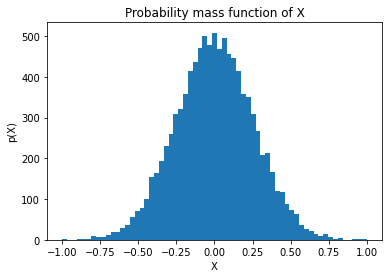

In [6]:
np.random.seed(42)
n = 10000 # number of samples
x = np.random.randn(n, 1)
mu = np.sum(x) / n
x -= mu # ensure zero mean
# normalisation so that D_x = [-1, 1]
a = np.max(x)
b = np.min(x)

X = OrthogonalPolynomials(1/(b-a)*(2*x-a-b), degree = 2)

hist, bin_edges = X.pmf(plot = True)

To construct the polynomials the following recursive formula is employed:

$$\pi_{k+1}(x) = (x- \alpha_k)\pi_k(x) - \beta_k\pi_{k-1}(x)$$
$$\alpha_k = \frac{\langle x\pi_{k},\pi_k\rangle_w}{\langle \pi_{k},\pi_{k}\rangle_w}$$
$$\beta_k = \frac{\langle \pi_{k},\pi_k\rangle_w}{\langle \pi_{k-1},\pi_{k-1}\rangle_w}$$

Where $\pi_k(x)$ is a monomic polynomial of degree k.

While $\pi_0(x) = 1$ can be chosen arbitrarily, $\pi_1(x) = ax + b$ need to be chosen in order to be orthogonal to 1. 
This is done by imposing:

$$\langle \pi_1, 1\rangle_w = 0$$
$$\int_{\mathcal{D}_x}\pi_1w(x)dx = \int_{\mathcal{D}_x}(ax + b)w(x)dx = a\int_{\mathcal{D}_x}xw(x)dx +b\int_{\mathcal{D}_x}w(x)dx = 0 $$
$$a\mathbb{E}[x] + b = 0 \Rightarrow b = -a\mathbb{E}[x] $$

By this calculation we can deduce that if $\mathbb{E}[x] = 0$ we have $b= 0$ for any $a$, which we can arbitrarily set to 1, giving $\pi_1(x) = x$. To ensure that $x$ has zero mean is sufficient to subtract it at the beginning.

It is possible now to retrieve any orthogonal polynomial. For example the coefficients for $\pi_2(x)$ are:

Coefficients of the polynomial:
[1.00000000000000, 0.0432012311883071, -0.0656111382533231]


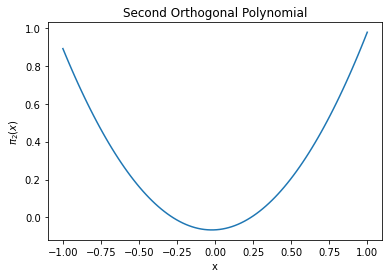

In [17]:
pi_2 = X.orthogonal_polynomial()
print('Coefficients of the polynomial:')
print(X.coefficients)

x_plot = np.linspace(-1,1,100)
fig, ax = plt.subplots()
ax.plot(x_plot, pi_2(x_plot))
ax.set_xlabel('x')
ax.set_ylabel(r'$\pi_2(x)$')
ax.set_title('Second Orthogonal Polynomial')
plt.show()


In order to chek the correctness of the code we can try to reproduce some analytical results. In particular we know that for a uniform distribution with support $\mathcal{D}_x = [-1, 1]$ the set of orthogonal polynomials is given by the Legendre polynomials, given by:

$$P_0(x) = 1; \quad P_1(x) = x$$
$$(k+1)P_{k+1}(x) = (2k + 1)xP_k(x) - kP_{k-1}(x)$$
$$\Rightarrow P_2(x) = \frac{1}{2}(3x^2 - 1)$$


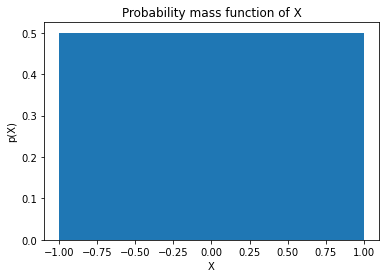

Coefficients of the polynomial:
[1.00000000000000, 0.00465094360653518, -0.332303006306604]


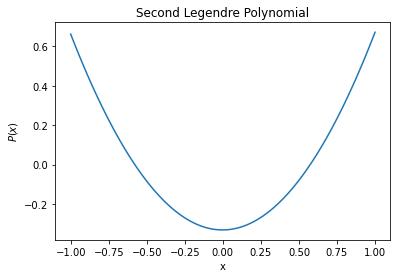

In [18]:
x_uniform = np.linspace(-1,1,n*1000)
x_uniform = np.array([x_uniform])
X_Legendre = OrthogonalPolynomials(x_uniform, degree = 2)

hist, bin_edges = X_Legendre.pmf(plot = True)

P_2 = X_Legendre.orthogonal_polynomial()
print('Coefficients of the polynomial:')
print(X_Legendre.coefficients)

x_plot = np.linspace(-1,1,100)
fig, ax = plt.subplots()
ax.plot(x_plot, P_2(x_plot))
ax.set_xlabel('x')
ax.set_ylabel(r'$P(x)$')
ax.set_title('Second Legendre Polynomial')
plt.show()

The Legendre polynomial is retrieved by multiplying the obtained coefficients times 3/2.

Unfortunately the algorithm seems very slow to converge to the right solution (note the `n*1000`). This might be due to the numerical integration and the automatic sizing of the bins for the histogram

[1] Sudret, B. (2014) Polynomial chaos expansions and stochastic finite element methods, In: Risk and Reliability in Geotechnical Engineering (Chap. 6), K.-K. Phoon & J. Ching (Eds.), pp. 265-300, CRC Press.